In [1]:
import csv
from xml.etree import ElementTree
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import StrMethodFormatter
import statsmodels.api as sm
import scipy.stats as stats
from pyclustertend import hopkins, vat, assess_tendency_by_mean_metric_score
from sklearn.preprocessing import scale, MinMaxScaler, minmax_scale, RobustScaler,robust_scale, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

import time
import warnings

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from itertools import cycle, islice

In [2]:
def get_data():
    file = "C:/Users/aprodea/work/metrics-tax-compare/merged/merged_filledna.csv"
    data = pd.read_csv(file, sep=';')
    return data

merged_data = get_data()
merged_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),14.0,3.0,0,1.0,1.0,0,2,2.0,4.0
1,GES_GRT.GES_GRTCoreModule.Initialize(),1.0,1.0,0,0.0,0.0,0,0,1.0,4.0
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),2.0,1.0,0,0.0,0.0,0,1,1.0,4.0
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,2.0,1.0,0,0.0,0.0,5,0,1.0,3707.0
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),2.0,1.0,0,0.0,0.0,4,0,1.0,2358.0
...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,8.0,1.0,1,0.0,0.0,1,3,4.0,4.0
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,3.0,2,0.0,1.0,1,2,1.0,8.0
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,6.0,2,0.0,1.0,1,2,1.0,8.0
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,2.0,1.0,1,0.0,0.0,0,1,17.0,4.0


In [3]:
list_columns = merged_data.columns.tolist()
list_columns.remove('Method')
list_columns

['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall']

In [10]:
scaled_data = merged_data.copy()

for col_name in list_columns:
    col = scaled_data[col_name]
    min_col, max_col = col.min(), col.max()
    min_col = 0  # consider min as 0 to perserve the importance of values; eg LOC 25, 50 -> 0.5, 1 
#     print(col_name, min_col, max_col)
    new_min, new_max = 0, 100
    scaled_data[col_name] = new_min + ((col - min_col) * (new_max - new_min) / (max_col - min_col))
    
scaled_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),15.053763,4.225352,0.000000,2.040816,10.0,0.000000,2.564103,5.128205,0.011541
1,GES_GRT.GES_GRTCoreModule.Initialize(),1.075269,1.408451,0.000000,0.000000,0.0,0.000000,0.000000,2.564103,0.011541
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),2.150538,1.408451,0.000000,0.000000,0.0,0.000000,1.282051,2.564103,0.011541
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,2.150538,1.408451,0.000000,0.000000,0.0,11.627907,0.000000,2.564103,10.695635
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),2.150538,1.408451,0.000000,0.000000,0.0,9.302326,0.000000,2.564103,6.803428
...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,8.602151,1.408451,7.142857,0.000000,0.0,2.325581,3.846154,10.256410,0.011541
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.075269,4.225352,14.285714,0.000000,10.0,2.325581,2.564103,2.564103,0.023082
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.075269,8.450704,14.285714,0.000000,10.0,2.325581,2.564103,2.564103,0.023082
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,2.150538,1.408451,7.142857,0.000000,0.0,0.000000,1.282051,43.589744,0.011541


In [11]:
scaled_data[list_columns]

,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall
0,15.053763,4.225352,0.000000,2.040816,10.0,0.000000,2.564103,5.128205,0.011541
1,1.075269,1.408451,0.000000,0.000000,0.0,0.000000,0.000000,2.564103,0.011541
2,2.150538,1.408451,0.000000,0.000000,0.0,0.000000,1.282051,2.564103,0.011541
3,2.150538,1.408451,0.000000,0.000000,0.0,11.627907,0.000000,2.564103,10.695635
4,2.150538,1.408451,0.000000,0.000000,0.0,9.302326,0.000000,2.564103,6.803428
...,...,...,...,...,...,...,...,...,...
799,8.602151,1.408451,7.142857,0.000000,0.0,2.325581,3.846154,10.256410,0.011541
800,1.075269,4.225352,14.285714,0.000000,10.0,2.325581,2.564103,2.564103,0.023082
801,1.075269,8.450704,14.285714,0.000000,10.0,2.325581,2.564103,2.564103,0.023082
802,2.150538,1.408451,7.142857,0.000000,0.0,0.000000,1.282051,43.589744,0.011541


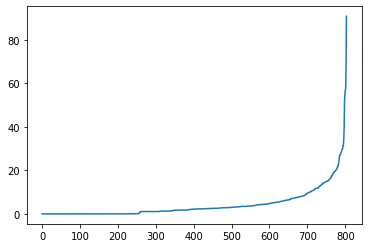

In [12]:
X = scaled_data[list_columns]
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [13]:
dbscan = cluster.DBSCAN(eps=20)
dbscan.fit(scaled_data[list_columns])

DBSCAN(eps=20)

In [14]:
dbscan.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0, -1,  0, -1, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [16]:
labels = dbscan.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 40


In [17]:
scaled_data['CLevel'] = labels
scaled_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),15.053763,4.225352,0.000000,2.040816,10.0,0.000000,2.564103,5.128205,0.011541,0
1,GES_GRT.GES_GRTCoreModule.Initialize(),1.075269,1.408451,0.000000,0.000000,0.0,0.000000,0.000000,2.564103,0.011541,0
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),2.150538,1.408451,0.000000,0.000000,0.0,0.000000,1.282051,2.564103,0.011541,0
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,2.150538,1.408451,0.000000,0.000000,0.0,11.627907,0.000000,2.564103,10.695635,0
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),2.150538,1.408451,0.000000,0.000000,0.0,9.302326,0.000000,2.564103,6.803428,0
...,...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,8.602151,1.408451,7.142857,0.000000,0.0,2.325581,3.846154,10.256410,0.011541,0
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.075269,4.225352,14.285714,0.000000,10.0,2.325581,2.564103,2.564103,0.023082,0
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.075269,8.450704,14.285714,0.000000,10.0,2.325581,2.564103,2.564103,0.023082,0
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,2.150538,1.408451,7.142857,0.000000,0.0,0.000000,1.282051,43.589744,0.011541,0


In [ ]:
noise = scaled_data[scaled_data['CLevel'] == -1]
first = scaled_data[scaled_data['CLevel'] == 0]
# second = scaled_data[scaled_data['CLevel'] == 1] 
# thrid = scaled_data[scaled_data['CLevel'] == 2]

# print(len(first), len(second), len(thrid))

In [18]:
def to_string_label(value):
    if value == 0:
        return "low"
    elif value == 1:
        return "regular"
    elif value == 2:
        return "high"
    elif value == -1:
        return "noise"
scaled_data['CLevelLbl'] = scaled_data['CLevel'].apply(to_string_label)
scaled_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel,CLevelLbl
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),15.053763,4.225352,0.000000,2.040816,10.0,0.000000,2.564103,5.128205,0.011541,0,low
1,GES_GRT.GES_GRTCoreModule.Initialize(),1.075269,1.408451,0.000000,0.000000,0.0,0.000000,0.000000,2.564103,0.011541,0,low
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),2.150538,1.408451,0.000000,0.000000,0.0,0.000000,1.282051,2.564103,0.011541,0,low
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,2.150538,1.408451,0.000000,0.000000,0.0,11.627907,0.000000,2.564103,10.695635,0,low
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),2.150538,1.408451,0.000000,0.000000,0.0,9.302326,0.000000,2.564103,6.803428,0,low
...,...,...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,8.602151,1.408451,7.142857,0.000000,0.0,2.325581,3.846154,10.256410,0.011541,0,low
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.075269,4.225352,14.285714,0.000000,10.0,2.325581,2.564103,2.564103,0.023082,0,low
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.075269,8.450704,14.285714,0.000000,10.0,2.325581,2.564103,2.564103,0.023082,0,low
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,2.150538,1.408451,7.142857,0.000000,0.0,0.000000,1.282051,43.589744,0.011541,0,low


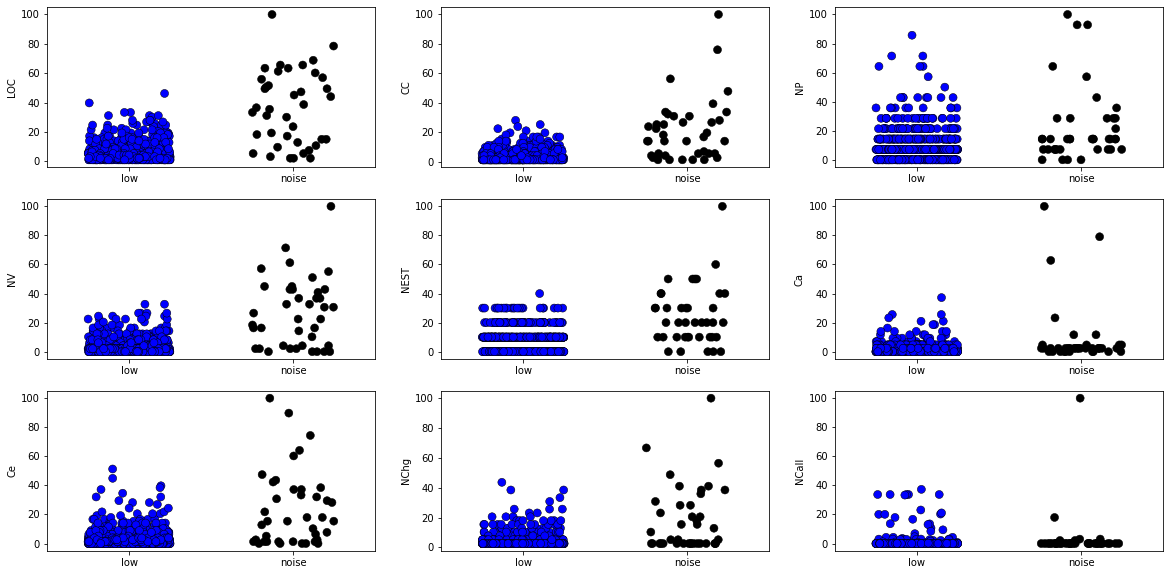

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
ax = axes.flatten()
for i in range(len(list_columns)):
    col_name = list_columns[i]
    sns.stripplot(data=scaled_data, x='CLevelLbl', y=col_name, 
#                   hue='CLevelLbl', 
                  palette={'low':'blue', 'regular':'#DCB732', 'high':'red', 'noise': 'black'},
                  jitter=0.25, size=8, ax=ax[i], linewidth=.5,
#                   order=["low", "regular", "high"]
                 )
    ax[i].set_ylabel(col_name)
    ax[i].set_xlabel("")

plt.show()

In [ ]:
df = scaled_data.copy()
list_columns = ['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall']
# df = df.stack()
df = pd.melt(df, id_vars=['Method', 'CLevelLbl'], value_vars=list_columns)
df

In [ ]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
sns.stripplot(data=df, x='variable', y='value', hue='CLevelLbl',
              palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
              hue_order=["low", "regular", "high"],
              jitter=0.25, size=8, ax=ax, linewidth=.5, dodge=True)

plt.show()

In [ ]:
merged_data['CLevel'] = groups
merged_data

In [ ]:
def to_string_label(value):
    if value == 0:
        return "low"
    elif value == 1:
        return "regular"
    if value == 2:
        return "high"
merged_data['CLevel'] = merged_data['CLevel'].apply(to_string_label)
merged_data

In [ ]:
low_critical = len(merged_data[merged_data['CLevel'] == "low"])
regular_critical = len(merged_data[merged_data['CLevel'] == "regular"]) 
high_critical = len(merged_data[merged_data['CLevel'] == "high"])

print(low_critical, regular_critical, high_critical)

In [ ]:
high_critical_data = merged_data[merged_data['CLevel'] == "high"]
high_critical_data.to_csv("C:/Users/aprodea/work/metrics-tax-compare/merged/high_critical_data_em_gmm.csv", sep=';', index=False)

In [ ]:
from pywaffle import Waffle

data = {'Low critical': low_critical, 'Regular critical': regular_critical, 'High critical': high_critical}

fig = plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    values=data, 
    colors=("#232066", "#DCB732", "#983D3D"),
    labels=['Low critical', 'Regular critical', 'High critical'],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
    interval_ratio_x=0.5,
    interval_ratio_y=0.5,
    figsize=(20,10)
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('#EEEEEE')
plt.show()

In [ ]:
data_class = merged_data.copy()

def split_at_last_point(s):
    idx = s.rfind('.')
    return s[:idx], s[idx+1:]
def split_method_name(value):
    parent, method_name = split_at_last_point(value)
    parent, class_name = split_at_last_point(parent)
    return pd.Series([parent, class_name, method_name])

data_class[['Parent_class', 'Class', 'Method']] = data_class['Method'].apply(split_method_name)
data_class

In [ ]:
import plotly.express as px

config = dict({'scrollZoom': True})

fig = px.treemap(data_class, path=['Parent_class', 'Class', 'Method'], values='LOC', color='CLevel',
                  color_discrete_map={'(?)':'black', 'low':'blue', 'regular':'yellow', 'high':'red'})
fig.show(config=config)